In [1]:
import dask.dataframe as dd
from dask.array import from_array
import rasterio as rio
from rasterio.enums import Resampling
from rasterio.features import shapes
from rasterio.mask import mask

from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, confusion_matrix, roc_curve
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from scipy.ndimage import binary_dilation
from scipy.spatial import cKDTree
from shapely.geometry import shape, box
from shapely.ops import unary_union
import geopandas as gpd


c:\Users\HOME\anaconda3\lib\site-packages\sklearn\experimental\enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


## Carga de Variables

In [2]:
# Función para ajustar la longitud de los arrays
def adjust_length(array, desired_length):
    current_length = len(array)
    if current_length > desired_length:
        # Recortar el array
        return array[:desired_length]
    elif current_length < desired_length:
        # Rellenar el array con NaNs
        return np.concatenate([array, np.full(desired_length - current_length, np.nan)])
    else:
        return array

In [3]:
# Ruta al archivo raster del inventario
raster_path_inventario = r"C:\Users\HOME\radar_antioquia_sentinel\raster\inventario.tif"
output_path = r"C:\Users\HOME\radar_antioquia_sentinel\raster\inventario_filtrado.tif"

# Leer el raster de inventario
with rio.open(raster_path_inventario) as src:
    inventario = src.read(1)  # Leer la capa
    meta = src.meta  # Leer los metadatos
    meta.update(dtype='float32', nodata=np.nan)  # Actualizar metadatos para el nuevo raster

# Identificar celdas con y sin movimientos en masa
con_deslizamientos = (inventario == 1)
sin_deslizamientos = (inventario == 0)

# Aplicar un filtro de dilatación binaria para expandir las áreas de movimientos en masa
# Esto creará un "buffer" alrededor de las celdas con movimientos en masa
buffer_celdas = binary_dilation(con_deslizamientos, structure=np.ones((2, 2)))

# Filtrar celdas sin deslizamientos que estén dentro del buffer
filtrado_sin_deslizamientos = sin_deslizamientos & buffer_celdas

# Crear el nuevo raster con las celdas de interés
nuevo_raster = np.full_like(inventario, np.nan, dtype='float32')
nuevo_raster[con_deslizamientos] = 1  # Mantener celdas con movimientos en masa
nuevo_raster[filtrado_sin_deslizamientos] = 0  # Agregar celdas sin deslizamientos pero cercanas

# Guardar el nuevo raster
with rio.open(output_path, 'w', **meta) as dst:
    dst.write(nuevo_raster, 1)

print(f"Nuevo raster guardado en: {output_path}")


Nuevo raster guardado en: C:\Users\HOME\radar_antioquia_sentinel\raster\inventario_filtrado.tif


In [4]:
# Ruta al archivo raster del inventario
raster_path_inventario = r"C:\Users\HOME\radar_antioquia_sentinel\raster\inventario_filtrado.tif"

# Leer los metadatos del raster
with rio.open(raster_path_inventario) as src:
    raster_meta_inventario = src.meta

# Imprimir los metadatos del raster
print(f"Metadatos del raster: {raster_meta_inventario}")

# Leer el raster sin modificar la resolución
with rio.open(raster_path_inventario) as src:
    inventario = src.read(1)

# Contar el número de celdas con movimientos en masa
num_movimientos_masa = np.sum(inventario == 1)
print(f"Número de celdas con movimientos en masa: {num_movimientos_masa}")

# Ravel y eliminar NaNs
inventario_vector = inventario.ravel()
inventario_vector_MenM = inventario_vector[~np.isnan(inventario_vector)]

print(f"Tamaño del vector original sin NaNs: {inventario_vector_MenM.shape}")

# Obtener la transformación del raster original
with rio.open(raster_path_inventario) as src:
    original_transform_inventario = src.transform
    original_cell_size_x_inventario = original_transform_inventario[0]
    original_cell_size_y_inventario = -original_transform_inventario[4]

print(f"Tamaño de la celda original: {original_cell_size_x_inventario} x {original_cell_size_y_inventario}")

# Verificar el conteo de valores en el vector 'inventario_vector_MenM'
unique, counts = np.unique(inventario_vector_MenM, return_counts=True)
inventario_counts = dict(zip(unique, counts))
print(f"Conteo de valores en el vector inventario: {inventario_counts}")

# Contar celdas sin deslizamientos (valor 0)
num_sin_deslizamientos = inventario_counts.get(0, 0)
print(f"Número de celdas sin deslizamientos: {num_sin_deslizamientos}")

Metadatos del raster: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 35798, 'height': 38309, 'count': 1, 'crs': CRS.from_epsg(9377), 'transform': Affine(10.0, 0.0, 4544725.24,
       0.0, -10.0, 2540302.7176)}
Número de celdas con movimientos en masa: 4935
Tamaño del vector original sin NaNs: (19676,)
Tamaño de la celda original: 10.0 x 10.0
Conteo de valores en el vector inventario: {0.0: 14741, 1.0: 4935}
Número de celdas sin deslizamientos: 14741


In [5]:
# Ruta al archivo raster de susceptibilidad
raster_path_susceptibilidad = r"C:\Users\HOME\radar_antioquia_sentinel\raster\susceptibilidad.tif"

# Leer los metadatos del raster y el valor nodata
with rio.open(raster_path_susceptibilidad) as src:
    raster_meta_susceptibilidad = src.meta
    nodata_value_susceptibilidad = src.nodata

# Imprimir los metadatos del raster y el valor nodata
print(f"Metadatos del raster: {raster_meta_susceptibilidad}")
print(f"Valor Nodata: {nodata_value_susceptibilidad}")

# Leer el raster sin modificar la resolución
with rio.open(raster_path_susceptibilidad) as src:
    susceptibilidad = src.read(1)

# Reemplazar valores no válidos
susceptibilidad = np.where(susceptibilidad == nodata_value_susceptibilidad, np.nan, susceptibilidad)

# Ravel y eliminar NaNs
susceptibilidad_vector = susceptibilidad.ravel()
susceptibilidad_vector_MenM = susceptibilidad_vector[~np.isnan(susceptibilidad_vector)]

print(f"Tamaño del vector sin NaNs: {susceptibilidad_vector_MenM.shape}")

# Ajustar la longitud del array a 19676
desired_length = 19676
susceptibilidad_vector_MenM = adjust_length(susceptibilidad_vector_MenM, desired_length)

print(f"Tamaño del vector ajustado: {len(susceptibilidad_vector_MenM)}")

# Obtener la transformación del raster original
with rio.open(raster_path_susceptibilidad) as src:
    original_transform_susceptibilidad = src.transform
    original_cell_size_x_susceptibilidad = original_transform_susceptibilidad[0]
    original_cell_size_y_susceptibilidad = -original_transform_susceptibilidad[4]

print(f"Tamaño de la celda original: {original_cell_size_x_susceptibilidad} x {original_cell_size_y_susceptibilidad}")
# Contar valores no NaN
count_valid_values = len(susceptibilidad_vector_MenM)

print(f"Cantidad de valores válidos en 'susceptibilidad_vector_MenM': {count_valid_values}")



Metadatos del raster: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.4028234663852886e+38, 'width': 35798, 'height': 38309, 'count': 1, 'crs': CRS.from_epsg(9377), 'transform': Affine(10.0, 0.0, 4544725.24,
       0.0, -10.0, 2540302.7176)}
Valor Nodata: -3.4028234663852886e+38
Tamaño del vector sin NaNs: (462827655,)
Tamaño del vector ajustado: 19676
Tamaño de la celda original: 10.0 x 10.0
Cantidad de valores válidos en 'susceptibilidad_vector_MenM': 19676


## Creación del DataFrame

In [6]:
# Crear DataFrame y reemplazar NaN con 0
d = {'susceptibilidad': susceptibilidad_vector_MenM, 'inventario': inventario_vector_MenM}
data = pd.DataFrame(d).fillna(0)
print(list(data.columns))

['susceptibilidad', 'inventario']


In [7]:
data.head()


,susceptibilidad,inventario
0,64.795586,0.0
1,28.360430,0.0
2,52.262951,0.0
3,45.167225,1.0
4,34.011242,0.0


In [ ]:
# Guardar el DataFrame en un archivo Parquet para liberar RAM
data.to_parquet(r'C:\Users\HOME\OneDrive - Universidad Nacional de Colombia\maestria_big_data\clases\TFM\codigo_TFM/data.parquet', index=False)

In [ ]:
# Liberar memoria RAM
del data

In [ ]:
# Liberar memoria RAM ocupada por las variables de inventario
del inventario, inventario_vector, original_transform_inventario
gc.collect()

In [ ]:
# Liberar memoria RAM ocupada por las variables de susceptibilidad
del susceptibilidad, susceptibilidad_vector, original_transform_susceptibilidad
gc.collect()

## Carga del DataFrame

In [2]:
# Cargar el DataFrame desde el archivo Parquet utilizando Dask
data_dd = dd.read_parquet(r'C:\Users\HOME\OneDrive - Universidad Nacional de Colombia\maestria_big_data\clases\TFM\codigo_TFM\data.parquet', engine='pyarrow')
#data_dd.head()

In [3]:
# Contar el número de registros con valor 0 y 1 en la columna 'inventario'
counts = data_dd['inventario'].value_counts().compute()

print(f"Conteo de valores en la columna 'inventario':")
print(counts)

Conteo de valores en la columna 'inventario':
0.0    14741
1.0     4935
Name: inventario, dtype: int64


## HistGradientBoostingClassifier

In [4]:
# Paso 1: Ajuste del Umbral de Clasificación
def evaluate_model_threshold(model, X, y, threshold=0.5):
    y_pred_proba = model.predict_proba(X)[:, 1]
    y_pred = (y_pred_proba > threshold).astype(int)
    print(f"Threshold: {threshold}")
    print("Confusion Matrix:")
    print(confusion_matrix(y, y_pred))
    print("Classification Report:")
    print(classification_report(y, y_pred))
    print(f"ROC AUC: {roc_auc_score(y, y_pred_proba)}")

In [5]:
# Convertir los datos de Dask a pandas
data_pd = data_dd.compute()

In [6]:
# Separar características y etiquetas de la muestra
X = data_pd['susceptibilidad'].values.reshape(-1, 1)
y = data_pd['inventario'].values

In [7]:
# Liberar memoria de los objetos que ya no se necesitan
del data_pd
gc.collect()

12

In [8]:
# Separar los datos en conjuntos de entrenamiento, prueba y validación
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

In [9]:
smote = SMOTE(random_state=42)
under_sampler = RandomUnderSampler(random_state=42)

In [10]:
# Combinación de SMOTE y submuestreo
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
X_train_balanced, y_train_balanced = under_sampler.fit_resample(X_train_balanced, y_train_balanced)

In [11]:
# Paso 2: Modelos Alternativos o Combinados usando StackingClassifier
base_learners = [
    ('hist', HistGradientBoostingClassifier(random_state=42)),
    ('tree', DecisionTreeClassifier(random_state=42)),
    ('logreg', LogisticRegression(max_iter=1000, random_state=42))
]

stack_model = StackingClassifier(
    estimators=base_learners,
    final_estimator=LogisticRegression(),
    n_jobs=-1
)

# Paso 3: Refinamiento de los Hiperparámetros usando RandomizedSearchCV con valores ampliados
param_dist = {
    'hist__learning_rate': [0.001, 0.01, 0.1, 0.3, 0.5, 0.7],  # Amplía el rango de tasas de aprendizaje
    'hist__max_iter': [50, 100, 150, 200, 250, 300, 400],     # Más iteraciones para mayor ajuste
    'hist__max_depth': [3, 5, 7, 10, 15, 20, 30, 40],         # Variar la profundidad máxima
    'hist__min_samples_leaf': [10, 20, 30, 50, 75, 100, 150], # Menor y mayor número de muestras por hoja
    'hist__max_leaf_nodes': [10, 15, 20, 31, 50, 75, 100],    # Variedad en número de nodos hoja
    'hist__class_weight': [
        {0: 1, 1: 5}, 
        {0: 1, 1: 10}, 
        {0: 1, 1: 20}, 
        {0: 1, 1: 50}, 
        'balanced'  # Agrega la opción 'balanced' para ajuste automático
    ]
}

random_search = RandomizedSearchCV(
    estimator=stack_model,
    param_distributions=param_dist,
    n_iter=50,  # Incrementa el número de iteraciones para explorar más combinaciones
    scoring='roc_auc',
    cv=5,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

In [12]:
# Entrenar el modelo
random_search.fit(X_train_balanced, y_train_balanced)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5,
                   estimator=StackingClassifier(estimators=[('hist',
                                                             HistGradientBoostingClassifier(random_state=42)),
                                                            ('tree',
                                                             DecisionTreeClassifier(random_state=42)),
                                                            ('logreg',
                                                             LogisticRegression(max_iter=1000,
                                                                                random_state=42))],
                                                final_estimator=LogisticRegression(),
                                                n_jobs=-1),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'hist__class_weight': [{0: 1, 1: 5},
                                                               {0: 1, 1: 10},
                                                               {0: 1, 1: 20},
                                                               {0: 1, 1: 50},
                                                               'balanced'],
                                        'hist__learning_rate': [0.001, 0.01,
                                                                0.1, 0.3, 0.5,
                                                                0.7],
                                        'hist__max_depth': [3, 5, 7, 10, 15, 20,
                                                            30, 40],
                                        'hist__max_iter': [50, 100, 150, 200,
                                                           250, 300, 400],
                                        'hist__max_leaf_nodes': [10, 15, 20, 31,
                                                                 50, 75, 100],
                                        'hist__min_samples_leaf': [10, 20, 30,
                                                                   50, 75, 100,
                                                                   150]},
                   random_state=42, scoring='roc_auc', verbose=2)

In [13]:
# Mejor modelo
best_model = random_search.best_estimator_
print("Best parameters found: ", random_search.best_params_)

Best parameters found:  {'hist__min_samples_leaf': 10, 'hist__max_leaf_nodes': 100, 'hist__max_iter': 250, 'hist__max_depth': 40, 'hist__learning_rate': 0.3, 'hist__class_weight': {0: 1, 1: 50}}


Evaluación en el Conjunto de Validación:

--- Evaluación del Modelo con Umbral de Predicción: 0.3 ---
Precisión del Modelo (Accuracy): 0.26
AUC-ROC (Área Bajo la Curva): 0.51

--- Matriz de Confusión ---
La matriz de confusión muestra cómo el modelo clasifica correctamente o se equivoca en las predicciones:


c:\Users\HOME\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\HOME\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\HOME\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


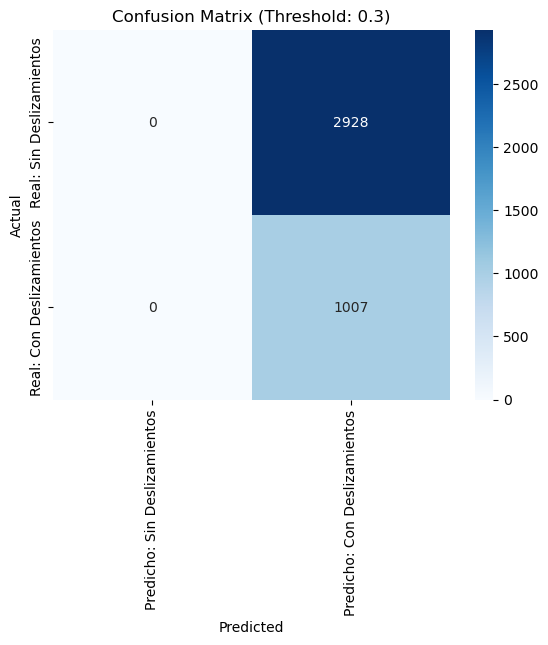


--- Reporte de Clasificación ---
El reporte de clasificación incluye precisión, recall y f1-score para cada clase:
                    precision    recall  f1-score   support

Sin Deslizamientos       0.00      0.00      0.00      2928
Con Deslizamientos       0.26      1.00      0.41      1007

          accuracy                           0.26      3935
         macro avg       0.13      0.50      0.20      3935
      weighted avg       0.07      0.26      0.10      3935

Evaluación en el Conjunto de Prueba:


c:\Users\HOME\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



--- Evaluación del Modelo con Umbral de Predicción: 0.3 ---
Precisión del Modelo (Accuracy): 0.25
AUC-ROC (Área Bajo la Curva): 0.48

--- Matriz de Confusión ---
La matriz de confusión muestra cómo el modelo clasifica correctamente o se equivoca en las predicciones:


c:\Users\HOME\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\HOME\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


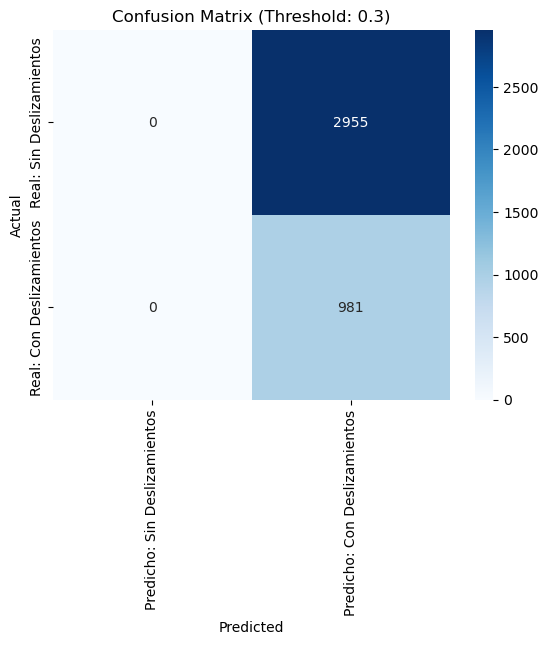


--- Reporte de Clasificación ---
El reporte de clasificación incluye precisión, recall y f1-score para cada clase:
                    precision    recall  f1-score   support

Sin Deslizamientos       0.00      0.00      0.00      2955
Con Deslizamientos       0.25      1.00      0.40       981

          accuracy                           0.25      3936
         macro avg       0.12      0.50      0.20      3936
      weighted avg       0.06      0.25      0.10      3936



In [14]:
def evaluate_model_threshold(model, X, y, threshold=0.3):
    # Obtener las probabilidades de predicción
    y_pred_proba = model.predict_proba(X)[:, 1]
    
    # Aplicar el umbral para definir la clase predicha
    y_pred = (y_pred_proba >= threshold).astype(int)
    
    # Calcular métricas de evaluación
    accuracy = accuracy_score(y, y_pred)
    roc_auc = roc_auc_score(y, y_pred_proba)
    report = classification_report(y, y_pred, target_names=['Sin Deslizamientos', 'Con Deslizamientos'])
    conf_matrix = confusion_matrix(y, y_pred)

    # Imprimir resultados con explicaciones claras
    print(f"\n--- Evaluación del Modelo con Umbral de Predicción: {threshold} ---")
    print(f"Precisión del Modelo (Accuracy): {accuracy:.2f}")
    print(f"AUC-ROC (Área Bajo la Curva): {roc_auc:.2f}")
    print("\n--- Matriz de Confusión ---")
    print("La matriz de confusión muestra cómo el modelo clasifica correctamente o se equivoca en las predicciones:")
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicho: Sin Deslizamientos', 'Predicho: Con Deslizamientos'], 
                yticklabels=['Real: Sin Deslizamientos', 'Real: Con Deslizamientos'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix (Threshold: {threshold})')
    plt.show()
    
    print("\n--- Reporte de Clasificación ---")
    print("El reporte de clasificación incluye precisión, recall y f1-score para cada clase:")
    print(report)

# Evaluar en conjunto de validación con ajuste de umbral
print("Evaluación en el Conjunto de Validación:")
evaluate_model_threshold(best_model, X_val, y_val, threshold=0.3)

# Evaluar en conjunto de prueba con ajuste de umbral
print("Evaluación en el Conjunto de Prueba:")
evaluate_model_threshold(best_model, X_test, y_test, threshold=0.3)
